## Learning how to use George

In [1]:
#We'll need some standard packages
import matplotlib.pyplot as plt
import numpy as np
import george as g

from scipy.optimize import minimize

I'll construct some test data. To begin with, I'm running through the example in the george docs.

In [30]:
# Test data
# np.random.seed(1234)
def f(x, yerr=None):
    if yerr is None: 
        yerr = np.zeros(x.shape)
    
    yo = np.sin(x) + yerr * np.random.randn(len(x)) +5

    # yo = 0.5 * x + yerr*np.random.randn(len(x))

    return yo

xo = 10 * np.sort(np.random.rand(15))
yoerr = 0.2 * np.ones_like(xo)
yo = f(xo, yoerr)

# Initialise the GP object
print('Variance of y: {}'.format(np.var(yo)))
print('Mean of y: {}'.format(np.mean(yo)))

Variance of y: 0.44264986771384435
Mean of y: 5.132590341609141


Now, I need to initialise the GP object. First, I create a kernel with the same width as the variance of yo as my prior, and a timescale of 0.5:

In [19]:
# Specify a (stationary) kernel with the variance of yo, the same mean as yo, and a length scale of 0.3
kernel = np.var(yo) * g.kernels.ExpSquaredKernel(0.3) + np.mean(yo)

print("Kernel has {} dimensions".format(kernel.ndim))
print("Kernel has {} parameter names".format(kernel.parameter_names))
for name in kernel.parameter_names:
    print('{:20}: {}'.format(name, kernel[name]))

Kernel has 1 dimensions
Kernel has ('k1:log_constant', 'k2:k1:log_constant', 'k2:k2:metric:log_M_0_0') parameter names
k1:log_constant     : 1.645100400669561
k2:k1:log_constant  : -0.7363971423830173
k2:k2:metric:log_M_0_0: -1.2039728043259361


### Note on Kernels:
The kernel is stationary, meaning that it ignores the value of the 'time' axis, only using the distance from the last data point as its inputs. This is converse to non-stationary kernels, which account for the location on the x-axis when computing their stuff. As an example, the following is a non-stationary, local gaussian kernel:

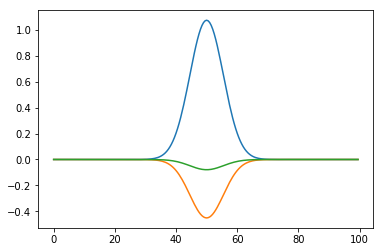

In [20]:
width = np.log(30)
eg = g.kernels.LocalGaussianKernel(location=50, log_width=width, ndim=1)
gp = g.GP(eg)

xp = np.arange(0, 100, 0.5)
yp = gp.sample(xp, 3)
for y in yp:
    plt.plot(xp, y)
plt.show()

You can see that the Gaussians have an equal chance of deviating up or down, depending on which wat the fluctuations go early on in the model.

### Actually fitting the test data

We're going to use the kerlen I made in cell 3 to generate this GP. The ExpSquaredKernel uses the following equation to model the correllation between two points:

$k(r^2)=exp\big(\frac{−r^2}{2}\big)$

where $r$ is the distance between the two data.

In [21]:
# Use that kernel to make a GP object
gp = g.GP(kernel)

# Pre-compute the covariance matrix and factorize it for a set of times and uncertainties.
gp.compute(xo, yoerr)
# This helps with speed later, and allows us to use the 'predict' function

In [22]:
# Define a prediction array of x values
xp = np.linspace(0, 10, 500)
# Use the GP to predict the values of y at these x
yp, yperr = gp.predict(yo, xp, return_var=True)


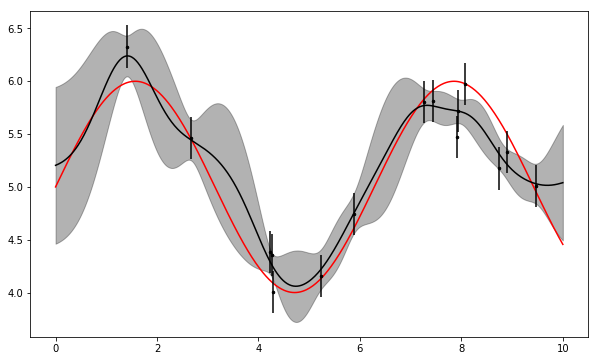

In [23]:
# Initialise plotting area
fig, ax = plt.subplots(figsize=[10,6])

# Plot the actual form of the posterior
ax.plot(xp, f(xp), color='red', zorder=1)
# Plot the prediction variance
ax.fill_between(xp, yp+np.sqrt(yperr), yp-np.sqrt(yperr),
    alpha=0.3, color='black')
# Plot the prediction means
ax.plot(xp, yp, color='black')
# Plot the data
ax.errorbar(xo, yo, yoerr, markersize=5, fmt='.k', capsize=0)

plt.show()

You can see that the actual posterior (red) is relatively well-modelled (grey) in general, but in between data the errors widen. However, we obviously want to improve the fit we have here...

In [24]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(yo)))

Initial ln-likelihood: -13.99


We can do better!

# Optimisation of the GP hiperparameters

The above is just our prior, we want to be able to fine tune the hiperparameters of the GP to better fit the data we have. We already have the tools; there is a built-in log_likelihood function in the GP! If we can minimise the *negative* log likelihood, we *maximise* the likelihood that our GP is giving the correct prior!

In [25]:
from scipy.optimize import minimize

# We need to convert our likelihood to the right stuff...
def neg_ln_like(p):
    # Get the log like for observables, p
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(yo)

def grad_neg_ln_like(p):
    # Get the gradient of the neg log like
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(yo)


Now, we can just run the GP through the minimize function, to figure out what parameters get the best likelihood

In [26]:
print("GP Parameter vector:\n{}\n".format(gp.get_parameter_vector()))

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(yo)))

GP Parameter vector:
[ 1.6451004  -0.73639714 -1.2039728 ]

      fun: 8.485228683421742
 hess_inv: array([[2.13109982, 0.07952057, 0.07940483],
       [0.07952057, 0.98377945, 0.45482701],
       [0.07940483, 0.45482701, 0.36165272]])
      jac: array([4.35777665e-06, 1.59390140e-06, 5.54068260e-06])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 12
     njev: 14
   status: 0
  success: True
        x: array([ 3.33067208, -0.01465456,  1.16709461])

Final ln-likelihood: -8.49


Now, our posterior should look a lot better...

In [27]:
# Use the GP to predict the values of y at these x
new_yp, new_yperr = gp.predict(yo, xp, return_var=True)

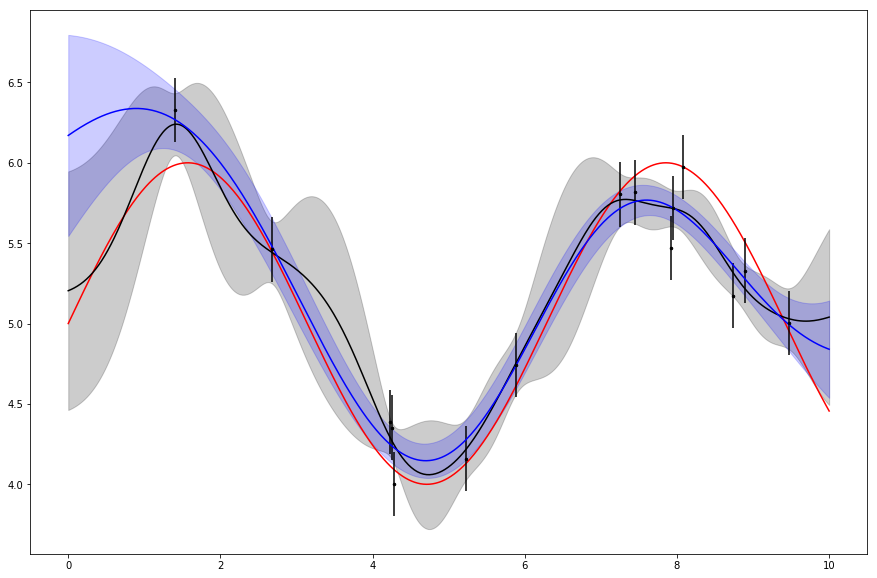

In [28]:
# Initialise plotting area
fig, ax = plt.subplots(figsize=[15,10])

# Data:
ax.plot(xp, f(xp), color='red', zorder=1)

# Prior:
ax.fill_between(xp, yp+np.sqrt(yperr), yp-np.sqrt(yperr),
    alpha=0.2, color='black')
ax.plot(xp, yp, color='black')

# Posterior:
ax.fill_between(xp, new_yp+np.sqrt(new_yperr), new_yp-np.sqrt(new_yperr),
    alpha=0.2, color='blue')
ax.plot(xp, new_yp, color='blue')


# Plot the data
ax.errorbar(xo, yo, yoerr, markersize=5, fmt='.k', capsize=0)

plt.show()

Note how much smoother the adjusted fit is.  The errors between data are also much nicer, and the agreement to the actual form of the data is much closer. 


Note that the kernel I'm using here thinks that the data have a mean of 0. If I extend the extrapolation range out, we get something like this:

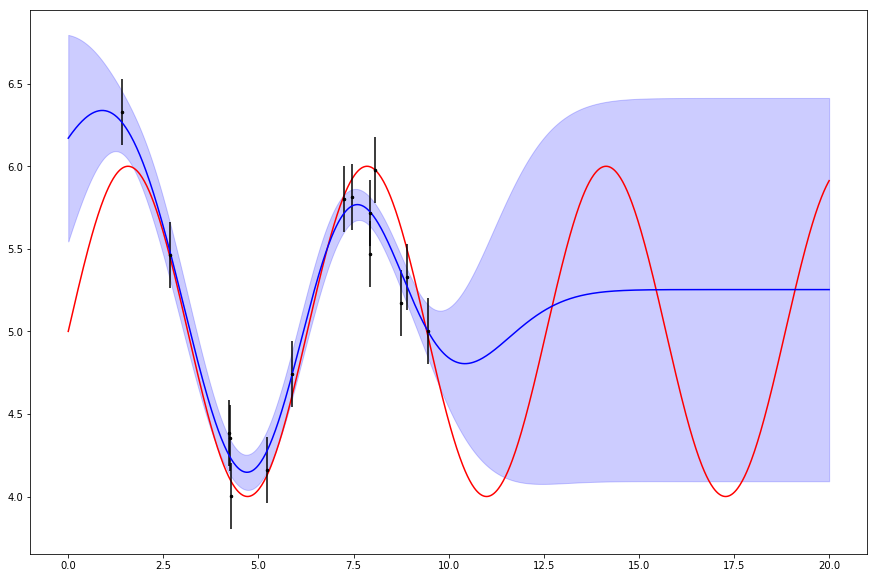

In [29]:
xp = np.linspace(0, 20, 1000)
new_yp, new_yperr = gp.predict(yo, xp, return_var=True)

# Initialise plotting area
fig, ax = plt.subplots(figsize=[15,10])

# Data:
ax.plot(xp, f(xp), color='red', zorder=1)

# Posterior:
ax.fill_between(xp, new_yp+np.sqrt(new_yperr), new_yp-np.sqrt(new_yperr),
    alpha=0.2, color='blue')
ax.plot(xp, new_yp, color='blue')


# Plot the data
ax.errorbar(xo, yo, yoerr, markersize=5, fmt='.k', capsize=0)

plt.show()

The predicted values quickly return to the mean.